[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Botiy/TerraTriad/blob/main/AirbusShipdetection.ipynb)

# Loading data and visualizing
## **Chosen method:** downloading the kaggle competition to the /content folder, then unzipping it
## **Important:** (this requires approximately 60GB temporarily) zip folder can be deleted after the unpacking, to regain 30GB of space

Authentication - here the kaggle.json file needs to be uploaded

In [ ]:
from google.colab import files
files.upload()  # Upload the kaggle.json file


Uploading and using authorization data

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the project to the /content folder

In [5]:
!kaggle competitions download -c airbus-ship-detection -p /content

100% 28.6G/28.6G [05:18<00:00, 153MB/s]
100% 28.6G/28.6G [05:18<00:00, 96.3MB/s]


Unzipping (the zip folder can then be safely deleted)

In [9]:
!unzip /content/airbus-ship-detection.zip -d /content/airbus-ship-detection


A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: /content/airbus-ship-detection/train_v2/f9775b70e.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f977a470c.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9780bfaf.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9782bdfe.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9785ca49.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f9785e462.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97a719d5.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97afa376.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97b85e3e.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bd0b11.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bd6b80.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97bfb1b2.jpg  
  inflating: /content/airbus-ship-detection/train_v2/f97c8cbbe.jpg  
  inflating: /content/airbus-ship-detection/train_v2

Checking whether the necessary elements are present

In [10]:
!ls /content/airbus-ship-detection

sample_submission_v2.csv  test_v2  train_ship_segmentations_v2.csv  train_v2


Sample usage - we draw 3 images from both the train_v2 and test_v2 folders

Displaying first 3 images from the train_v2 folder:


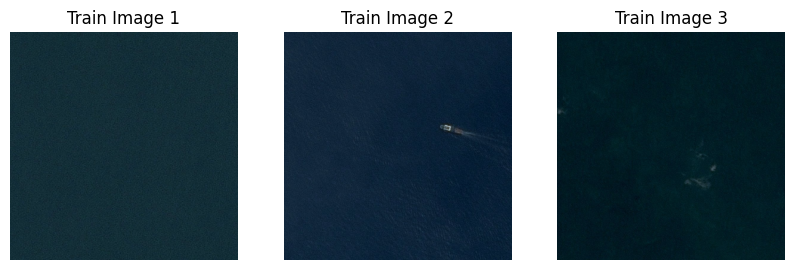

Displaying first 3 images from the test_v2 folder:


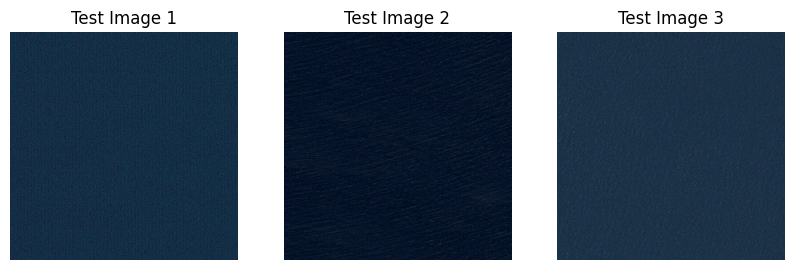

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# path of the train and test folders
train_folder = '/content/airbus-ship-detection/train_v2/'
test_folder = '/content/airbus-ship-detection/test_v2/'

# Get the first 3 image filenames from both train and test directories
train_images = os.listdir(train_folder)[:3]
test_images = os.listdir(test_folder)[:3]

# Function to display images
def show_images(image_folder, image_list, title):
    plt.figure(figsize=(10,5))
    for idx, image_file in enumerate(image_list):
        img_path = os.path.join(image_folder, image_file)
        img = Image.open(img_path)
        plt.subplot(1, 3, idx+1)
        plt.imshow(img)
        plt.title(f'{title} {idx+1}')
        plt.axis('off')  # Turn off axis labels for a cleaner look
    plt.show()

# Show first 3 train images
print("Displaying first 3 images from the train_v2 folder:")
show_images(train_folder, train_images, 'Train Image')

# Show first 3 test images
print("Displaying first 3 images from the test_v2 folder:")
show_images(test_folder, test_images, 'Test Image')


Count images based on the training file data and showing the head of the dataframe

In [12]:
import pandas as pd

# Load the annotations file
csv_path = '/content/airbus-ship-detection/train_ship_segmentations_v2.csv'
df = pd.read_csv(csv_path)

# Check for missing annotations
print(f"Number of images without ships: {df['EncodedPixels'].isna().sum()}")
print(f"Number of images with ships: {df['EncodedPixels'].notna().sum()}")

# Show the first few rows of the dataframe
df.head()


Number of images without ships: 150000
Number of images with ships: 81723


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Splitting the data and shuffling it

In [13]:
import random

# Shuffle the dataset (frac=1 means that it will keep all rows)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Determine the sizes for each split
total_images = len(df_shuffled)
train_size = int(0.8 * total_images)  # 80% for training
val_size = int(0.1 * total_images)    # 10% for validation
test_size = total_images - train_size - val_size  # Remaining for test

train_df = df_shuffled[:train_size]          # First 80% for training
val_df = df_shuffled[train_size:train_size + val_size]  # Next 10% for validation
test_df = df_shuffled[train_size + val_size:]  # Last 10% for testing

# Print the size of each set
print(f"Total images: {total_images}")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Total images: 231723
Training set size: 185378
Validation set size: 23172
Test set size: 23173


Checking image size

In [14]:
from PIL import Image
img = Image.open(os.path.join(train_folder, train_images[0]))
print(f"Image size: {img.size}")

Image size: (768, 768)


Converting RLE format to masked format

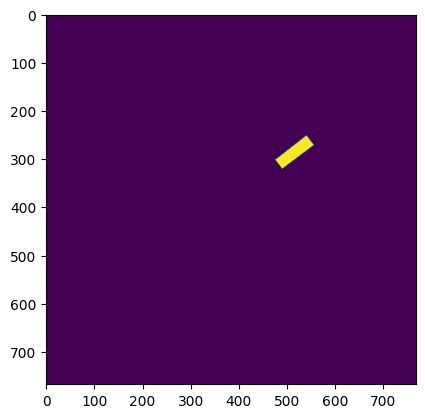

In [15]:
import numpy as np

# Convert RLE to mask
def rle_decode(mask_rle, shape=(768, 768)):
    if pd.isnull(mask_rle):  # Check if the RLE is NaN
        return np.zeros(shape, dtype=np.uint8)  # Return an empty mask if there's no ship

    s = mask_rle.split()  # Split the string into RLE parts
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for start, end in zip(starts, ends):
        img[start:end] = 1

    return img.reshape(shape).T  # Reshape and transpose to get the correct mask orientation

# Test on a single image
mask_rle = df.iloc[30]['EncodedPixels']
mask = rle_decode(mask_rle)
plt.imshow(mask)
plt.show()

Custom dataset class using pytorch

In [ ]:
#img

In [31]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms



class AirbusShipDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): A dataframe with ImageId and EncodedPixels (ship mask).
            image_dir (str): Directory where the images are stored.
            transform (callable, optional): Optional transform to be applied on the image and mask.
        """
        self.ships_frame = dataframe
        self.image_dir = image_dir
        self.transform = transform

        !mkdir /content/airbus-ship-detection/tmp

    def __len__(self):
        return len(self.ships_frame)

    def __getitem__(self, idx):
        # Get the image name
        img_name = self.ships_frame.iloc[idx, 0]
        tmp_file_path = f"/content/airbus-ship-detection/tmp/{img_name}"
        !unzip -p /content/airbus-ship-detection.zip train_v2/{img_name} > {tmp_file_path}
        # img_name = os.path.join(self.image_dir, self.ships_frame.iloc[idx, 0])
        # Load the image using PIL
        image = Image.open(tmp_file_path)

        # Get the RLE mask and decode it
        mask_rle = self.ships_frame.iloc[idx, 1]
        mask = rle_decode(mask_rle)

        # Convert image and mask to tensors
        image = np.array(image)

        if self.transform:
            # Apply transformations to both image and mask
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Convert to PyTorch tensors
        image = torch.from_numpy(image).float().div(255.0).permute(2, 0, 1)  # Change to [C, H, W] format
        # image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image) # Normalize the image for future stable learning
        mask = torch.from_numpy(mask).float().unsqueeze(0)         # Add channel dimension to mask

        return {'image': image, 'mask': mask}

Display masked image using a colormap

mkdir: cannot create directory ‘/content/airbus-ship-detection/tmp’: File exists


<ipython-input-32-ba6a347f199f>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 256)  # Start with a 'viridis' colormap


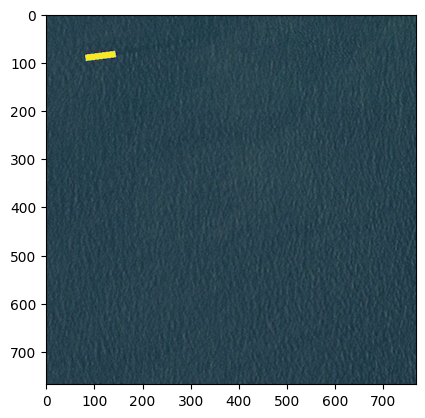

In [32]:
from matplotlib.colors import ListedColormap

dataset = AirbusShipDataset(df_shuffled, train_folder, transform=None)
datapoint = dataset[5228]


cmap = plt.cm.get_cmap('viridis', 256)  # Start with a 'viridis' colormap
new_cmap = cmap(np.arange(256))
new_cmap[0, :] = [1, 1, 1, 0]  # Set the first color to be transparent
new_cmap = ListedColormap(new_cmap)

plt.imshow(datapoint['image'].numpy().transpose(1, 2, 0))
plt.imshow(datapoint['mask'].numpy().transpose(1, 2, 0), cmap=new_cmap)